<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Computer%20Vision/Cancer_classification_using_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d mahyeks/almond-prunus-dulcis-damage-detection

In [ ]:
!kaggle datasets download -d waynemetcalf/meteor-camera-images-and-annotations-sony-imx291

In [ ]:
!kaggle datasets download -d ahmedsorour1/mri-for-brain-tumor-with-bounding-boxes

In [ ]:
!pip install torchinfo

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uzazam","key":"7abb2778b77e603b3a87069f481fc6a6"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change the permission

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d shashanks1202/skin-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/shashanks1202/skin-cancer-dataset
License(s): MIT
  0% 0.00/6.29M [00:00<?, ?B/s]
100% 6.29M/6.29M [00:00<00:00, 95.2MB/s]


In [ ]:
#!kaggle datasets download -d ahmedsorour1/mri-for-brain-tumor-with-bounding-boxes

Dataset URL: https://www.kaggle.com/datasets/ahmedsorour1/mri-for-brain-tumor-with-bounding-boxes
License(s): CC0-1.0
 87% 116M/133M [00:01<00:00, 97.6MB/s]
100% 133M/133M [00:01<00:00, 115MB/s] 


In [ ]:
!unzip '/content/skin-cancer-dataset.zip'

Archive:  /content/skin-cancer-dataset.zip
  inflating: train_cancer/benign/12.jpg  
  inflating: train_cancer/benign/13.jpg  
  inflating: train_cancer/benign/14.jpg  
  inflating: train_cancer/benign/17.jpg  
  inflating: train_cancer/benign/19.jpg  
  inflating: train_cancer/benign/20.jpg  
  inflating: train_cancer/benign/21.jpg  
  inflating: train_cancer/benign/22.jpg  
  inflating: train_cancer/benign/23.jpg  
  inflating: train_cancer/benign/24.jpg  
  inflating: train_cancer/benign/25.jpg  
  inflating: train_cancer/benign/26.jpg  
  inflating: train_cancer/benign/27.jpg  
  inflating: train_cancer/benign/28.jpg  
  inflating: train_cancer/benign/29.jpg  
  inflating: train_cancer/benign/3.jpg  
  inflating: train_cancer/benign/30.jpg  
  inflating: train_cancer/benign/32.jpg  
  inflating: train_cancer/benign/33.jpg  
  inflating: train_cancer/benign/34.jpg  
  inflating: train_cancer/benign/35.jpg  
  inflating: train_cancer/benign/36.jpg  
  inflating: train_cancer/benign/3

In [ ]:
import os
import shutil
import tempfile
import time


import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
#from torchinfo import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import cv2
import random
from PIL import Image
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from pathlib import Path

device = 'cuda'if torch.cuda.is_available() else 'cpu'

Setup data directory

In [ ]:
# setting up transform
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# creating tensor dataset from images
# root should be a string containing the path to the directory
dataset = datasets.ImageFolder(root='/content/train_cancer', # Changed X to the correct path
                              transform=data_transform,
                              target_transform=None)

# get the names of our labels
class_names = dataset.classes

visualizing a random image

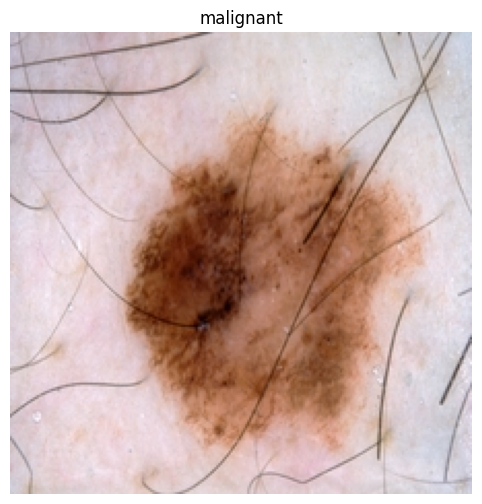

In [ ]:
random_idx = random.randint(0, len(dataset) - 1)
random_img, random_label = dataset[random_idx][0], dataset[random_idx][1]
img_permute = random_img.permute(1, 2, 0)

plt.figure(figsize=(8, 6))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[random_label]);

Creating Testing and Training Data

In [ ]:
# train test split on our dataset
training_size = int(0.7 * len(dataset))
testing_size = len(dataset) - training_size

train_data, test_data = torch.utils.data.random_split(dataset, [training_size, testing_size])

print(f"images in training set: {len(train_data)}")
print(f"images in testing set: {len(test_data)}")
print(f"total images: {len(dataset)}")

images in training set: 189
images in testing set: 81
total images: 270


Creating DataLoaders

In [ ]:
# creating dataloaders from train and test data
batch_size = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=batch_size,
                              num_workers=1,
                              shuffle=False)

Building Model

In [ ]:
# using a pretrained vit model
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit = torchvision.models.vit_b_16(weights=vit_weights).to(device)

# freeze the base parameters
for parameter in vit.parameters():
    parameter.requires_grad = False

# set number of classes
vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# import the summary function from torchinfo
from torchinfo import summary

# print a summary using torchinfo
summary(model=vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

Set up Loss Function and Optimizer¶


In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.0001,
                             betas=(0.9, 0.999),
                            weight_decay=0.2)

Defining Training and Testing Step

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch
    """
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 1. forward pass
        y_pred = model(X)

        # 2. calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """tests a PyTorch model for a single epoch
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Creating Training Loop

In [ ]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """trains and tests a PyTorch model with train_step() and test_step()
    """
    # create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # set model on device
    model.to(device)

    # training and testing loop
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # print loss and accuracy
        print(
          f"epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

Training Our Model

In [ ]:
# trainig our model with train()
vit_results = train(model=vit,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=20,
                  device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 1 | train_loss: 0.8387 | train_acc: 0.3335 | test_loss: 0.7904 | test_acc: 0.3830
epoch: 2 | train_loss: 0.7129 | train_acc: 0.5237 | test_loss: 0.6554 | test_acc: 0.6164
epoch: 3 | train_loss: 0.6053 | train_acc: 0.7056 | test_loss: 0.5527 | test_acc: 0.7678
epoch: 4 | train_loss: 0.5336 | train_acc: 0.7796 | test_loss: 0.4756 | test_acc: 0.8591
epoch: 5 | train_loss: 0.4782 | train_acc: 0.8375 | test_loss: 0.4217 | test_acc: 0.8995
epoch: 6 | train_loss: 0.4460 | train_acc: 0.8624 | test_loss: 0.3831 | test_acc: 0.9191
epoch: 7 | train_loss: 0.4268 | train_acc: 0.8723 | test_loss: 0.3588 | test_acc: 0.9191
epoch: 8 | train_loss: 0.4094 | train_acc: 0.8728 | test_loss: 0.3383 | test_acc: 0.9191
epoch: 9 | train_loss: 0.3996 | train_acc: 0.8728 | test_loss: 0.3252 | test_acc: 0.9191
epoch: 10 | train_loss: 0.3888 | train_acc: 0.8745 | test_loss: 0.3177 | test_acc: 0.9191
epoch: 11 | train_loss: 0.3849 | train_acc: 0.8728 | test_loss: 0.3110 | test_acc: 0.9191
epoch: 12 | train_l

Plotting Loss Curves

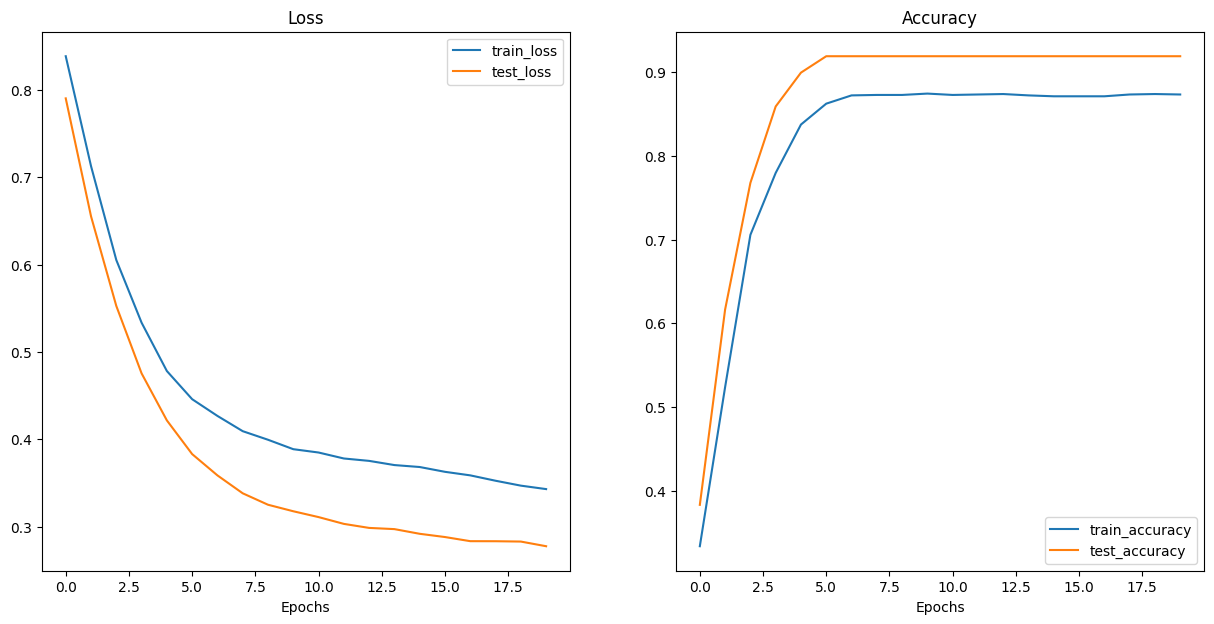

In [ ]:
def plot_loss_curves(results):
    """plots training curves of a results dictionary
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(vit_results)

Predicting Random Images

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # open image
    img = Image.open(image_path)

    # set transformation
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])

    ### Predict on image ###

    # set model to target device
    model.to(device)

    # evaluation mode
    model.eval()
    with torch.inference_mode():
      # add an extra dimension to image representing batch
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # predict image
      target_image_pred = model(transformed_image.to(device))

    # convert logits to probabilities with softmax function
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # get the label
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # plot
    plt.figure()
    plt.imshow(img)
    plt.title(f"pred: {class_names[target_image_pred_label]} | prob: {target_image_pred_probs.max():.3f} | actual: {image_path.parent.stem}")
    plt.axis(False);

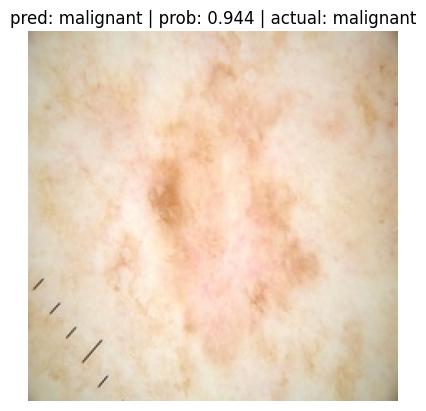

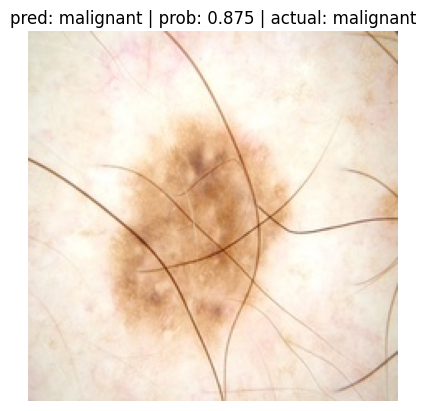

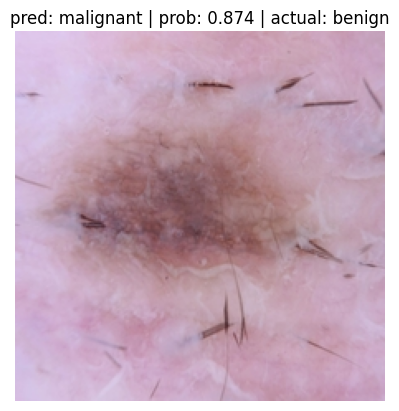

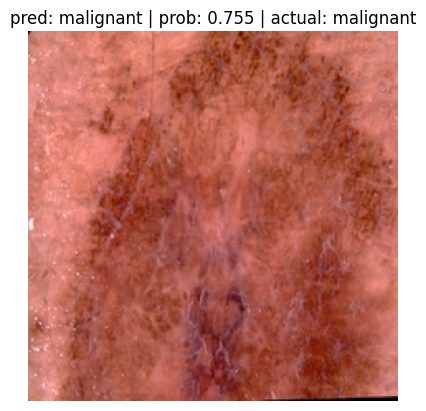

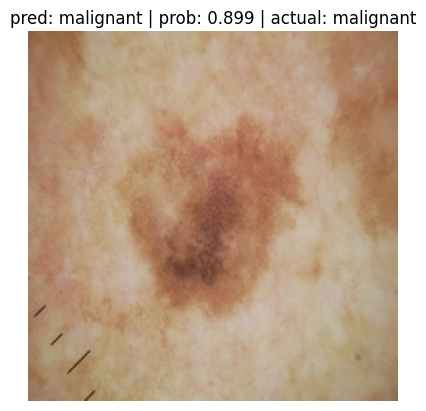

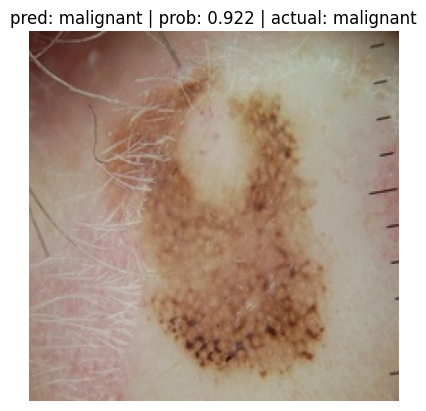

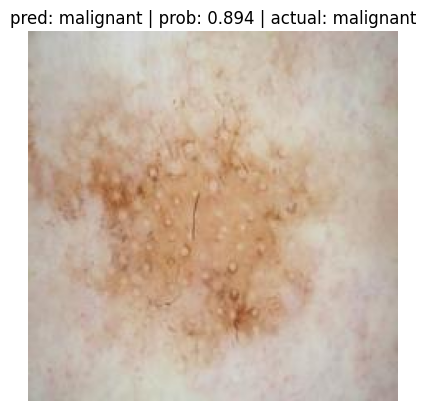

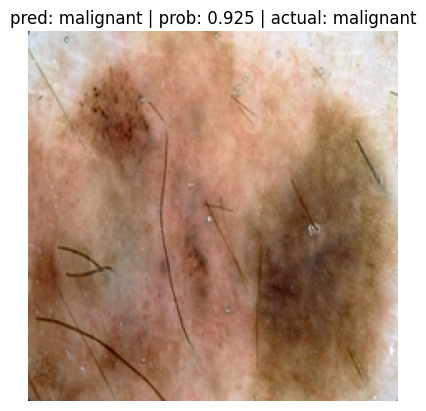

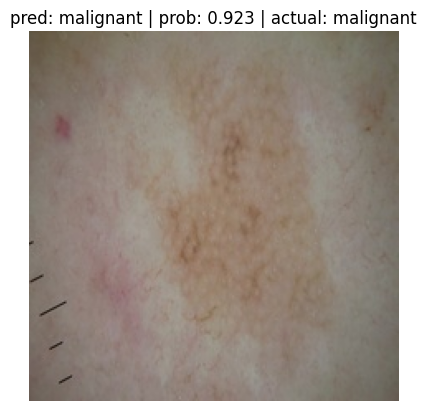

In [ ]:
# get random list of image paths
import random
num_images_to_plot = 9
test_image_path_list = list(Path('/content/train_cancer').glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# make prediction and plot image
for image_path in test_image_path_sample:
    pred_and_plot_image(model=vit,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))